In [1]:
# Calling libraries:
from __future__ import division
%matplotlib inline
import numpy as np, time, matplotlib.pyplot as plt, math, pandas, numpy.random as npr, pystan as ps, pickle
from pylab import plot, show, legend
from time import time
from scipy.stats import *
from tqdm import trange

In [2]:
sm = ps.StanModel(file="garch_WB.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f0ef85016fbe1114f4bfb9978c846a08 NOW.


In [15]:
T = 10**4
p = 50
q = 50
r = max(p,q)
d = 2
y = np.zeros(T)
X = npr.randn(d,T)
omega = npr.rand()
beta = npr.rand(p)/50
alpha = npr.rand(q)/50
b = npr.randn(d)

In [16]:
sigsq = np.ones(T)
for t in np.arange(0,r) :
    y[t] = np.sqrt(sigsq[t])*npr.randn() + b.dot(X[:,t])
for t in np.arange(r,T) :
    sigsq[t] = omega + beta.dot(sigsq[t-p:t]) + alpha.dot((y[t-q:t]-b.dot(X[:,t-q:t]))**2)
    y[t] = np.sqrt(sigsq[t])*npr.randn() + b.dot(X[:,t])

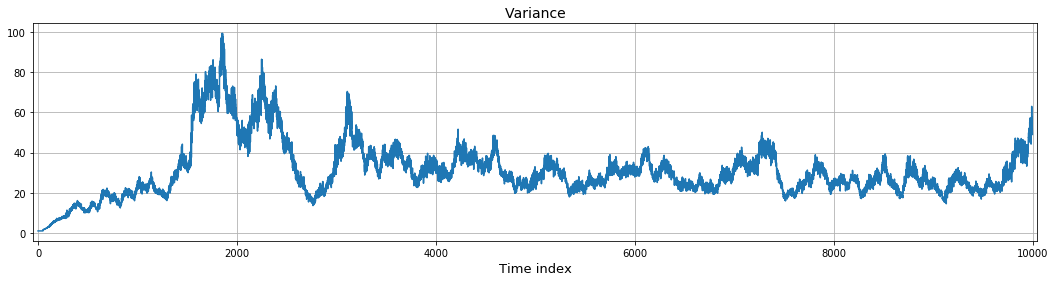

In [17]:
plt.figure(figsize=(18,4))
plt.plot(sigsq)
plt.xlim(-0.005*T,1.005*T)
plt.title("Variance", fontsize=14)
plt.xlabel("Time index", fontsize=13)
plt.grid(True)

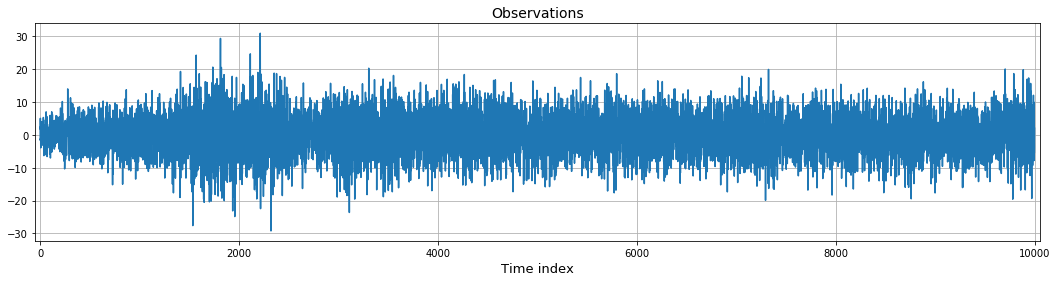

In [18]:
plt.figure(figsize=(18,4))
plt.plot(y)
plt.xlim(-0.005*T,1.005*T)
plt.title("Observations", fontsize=14)
plt.xlabel("Time index", fontsize=13);
plt.grid(True)

In [48]:
def acf(y, maxlag) :
    T = len(y)
    assert maxlag < T-10
    acfs = np.zeros(maxlag+1)
    for lag in trange(maxlag+1) :
        y1 = y[0:(T-lag)]
        y2 = y[lag:T]
        acfs[lag] = (np.mean(y1*y2) - np.mean(y1)*np.mean(y2))/(np.std(y1)*np.std(y2))
    return acfs

100%|██████████| 3001/3001 [00:01<00:00, 1523.18it/s]


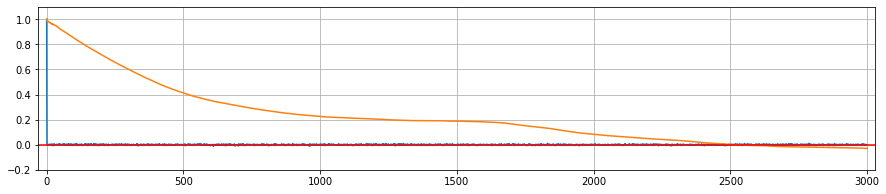

In [49]:
maxlag = 3000
acfs_y = acf(y,maxlag)
acfs_sigsq = acf(sigsq,maxlag)
plt.figure(figsize=(15,3))
plt.plot(acfs_y)
plt.plot(acfs_sigsq)
plt.grid(True)
plt.ylim(-0.2,1.1)
plt.axhline(y=0, color="red")
plt.xlim(-0.01*maxlag,1.01*maxlag);

In [32]:
acfs_sigsq

array([1.        , 0.99576814, 0.99511392, 0.99545752, 0.99428141,
       0.99367667, 0.99393071, 0.99387865, 0.99315336, 0.99367166,
       0.9920097 ])

### MCMC on full dataset:

In [79]:
n_chains = 10

tstart, tend = 0, T;
data = dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=1)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
trace = fit.extract()

62.86 minutes to run


In [83]:
file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "wb")
pickle.dump(trace, file)
file.close()

### Divide and conquer:

In [84]:
m = 10
tstarts = np.arange(m).astype(int)
tends = 1 + tstarts
tstarts *= int(T/m)
tends *= int(T/m)

In [ ]:
for i in range(m) :
    tstart, tend = tstarts[i], tends[i]
    dict(T=tend-tstart, p=p, q=q, r=max(p,q), d=d, y=y[tstart:tend], X=X[:,tstart:tend], power=T/(tend-tstart))
    fit = sm.sampling(data=data, thin=1, n_jobs=min(10,n_chains), chains=n_chains, init="random", iter=1_000)
    trace = fit.extract()
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "wb")
    pickle.dump(trace, file)
    file.close()

In [100]:
b_ci_dc = np.zeros((2,d))
beta_ci_dc = np.zeros((2,p))
alpha_ci_dc = np.zeros((2,q))
omega_ci_dc = np.zeros(2)
for i in range(m) :
    file = open("/xtmp/DC-BATS_data/garch/mcmc_wb_chunk"+str(i+1)+".pkl", "rb")
    trace = pickle.load(file)
    b_ci_dc += np.percentile(trace['b'],axis=0,q=[2.5,97.5])/m
    beta_ci_dc += np.percentile(trace['beta'],axis=0,q=[2.5,97.5])/m
    alpha_ci_dc += np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])/m
    omega_ci_dc += np.percentile(trace['omega'],axis=0,q=[2.5,97.5])/m

In [101]:
file = open("/xtmp/DC-BATS_data/garch/full_mcmc.pkl", "rb")
trace = pickle.load(file)
b_ci_full = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
beta_ci_full = np.percentile(trace['beta'],axis=0,q=[2.5,97.5])
alpha_ci_full = np.percentile(trace['alpha'],axis=0,q=[2.5,97.5])
omega_ci_full = np.percentile(trace['omega'],axis=0,q=[2.5,97.5])

### Compare credible intervals:

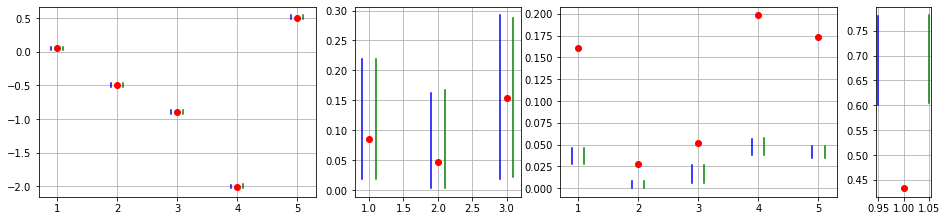

In [102]:
plt.rcParams['axes.grid'] = True
f, (a0, a1, a2, a3) = plt.subplots(1, 4, gridspec_kw={'width_ratios': [d, p, q, 1]}, figsize=(16,3.5))
b_ci = np.percentile(trace['b'],axis=0,q=[2.5,97.5])
a0.plot(np.arange(1,d+1), b, "ro")
for i in range(d) :
    a0.plot([i+0.9,i+0.9], b_ci_dc[:,i], "b-")
    a0.plot([i+1.1,i+1.1], b_ci_full[:,i], "g-")
a1.plot(np.arange(1,p+1), beta, "ro")
for i in range(p) :
    a1.plot([i+0.9,i+0.9], beta_ci_dc[:,i], "b-")
    a1.plot([i+1.1,i+1.1], beta_ci_full[:,i], "g-")
a2.plot(np.arange(1,q+1), alpha, "ro")
for i in range(q) :
    a2.plot([i+0.9,i+0.9], alpha_ci_dc[:,i], "b-")
    a2.plot([i+1.1,i+1.1], alpha_ci_full[:,i], "g-")
a3.plot(1, omega, "ro")
a3.plot([0.95,0.95], omega_ci_dc, "b-")
a3.plot([1.05,1.05], omega_ci_full, "g-");

In [103]:
b_ci_full

array([[ 0.02113235, -0.52107505, -0.92731504, -2.02784826,  0.48606604],
       [ 0.07245463, -0.46584072, -0.87268291, -1.97441711,  0.54153868]])

In [104]:
b_ci_dc

array([[ 0.02027293, -0.52114051, -0.92714667, -2.0287202 ,  0.48682246],
       [ 0.07377215, -0.46629418, -0.87247811, -1.97445259,  0.54180274]])